In [1]:
reload_lamb()
lamb.display.default(style=lamb.display.DerivStyle.PROOF)
# this is probably not a good idea to use generally, but it's currently useful here:
lamb.meta.ply.default_sopts['eliminate_sets'] = True

In [2]:
from lamb.meta.ply import derived, get_sopt
from lamb.meta import sets, true_term, quantifiers

# prototype implementation of a prefix union operator

class UnionOp(meta.quantifiers.RestrictedBindingOp):
    canonical_name = "Union"
    op_name_uni = "∪"
    op_name_latex = "\\bigcup{}"
    pre_simplify = True

    def __init__(self, var, body, /, restrictor=None, typ=None, **kwargs):
        self.type_constraint(body.type, types.SetType, constant=True)
        body, typ = self.type_constraint(body, typ,
                            error=f"`UnionOp` body and type should match")
    
        super().__init__(var, body, restrictor=restrictor, typ=body.type, **kwargs)

    def to_exists_form(self):
        outer_var = meta.term(self.find_safe_variable(), typ=self.type.content_type)
        inner_var = self.var_instance.copy()
        new_body = outer_var << self.body
        # if self.restrictor is not None:
        #     new_body = (inner_var << self.restrictor) & new_body
        result = sets.ConditionSet(outer_var,
                                   quantifiers.Exists(inner_var, new_body, self.restrictor))        
        return derived(result, self, f"∪{self.varname} => ∃")
    
    def eliminate(self, assignment=None, **sopts):
        if self.vacuous():
            # covers empty set / domain set as body
            return derived(self.body.copy(), self, f"trivial ∪{self.varname} elimination")
        elif self.finite_safe():
            a = self.scope_assignment(assignment=assignment)
            subs = [self[1].under_assignment(a | {self.varname : elem})
                    for elem in self.domain_iter()]
            return derived(sets.SetUnion.join(subs, empty=true_term),
                self,
                f"∪{self.varname} => ∪")
        # disable this for now -- it produces more complex formulas, not simpler ones
        # else:
        #     return self.to_exists_form()

        return self

    def simplify(self, assignment=None, **sopts):
        if (self.vacuous() or self.domain_cardinality() == 1
                    or get_sopt('eliminate_sets', sopts)):
            return self.eliminate(assignment=assignment, **sopts)
        return self

    # def try_adjust_type_local(self, unified_type, derivation_reason, env):
    #     args = self.args.copy()
    #     args[1] = args[1].try_adjust_type(unified_type,
    #                                      derivation_reason=derivation_reason)
    #     if args[1] is None:
    #         return None
    #     if self.varname in args[1].get_type_env().terms():
    #         # could do this conditionally
    #         args[0] = args[0].try_adjust_type(args[1].get_type_env().term_type(self.varname),
    #                                           derivation_reason=derivation_reason)
    #         if args[0] is None:
    #             return None
    #         if len(args) > 2:
    #             args[2] = args[2].try_adjust_type(types.SetType(args[0].type))
    #             if args[2] is None:
    #                 return None
    #     return self.copy_local(*args)

lamb.meta.core.registry.add_binding_op(UnionOp)

In [3]:
lamb.parsing.errors_raise = True
test = %te Union x_e << Human_{e}: {x}
test

(Union x_e << Human_{e}: {x_e})

In [4]:
test.to_exists_form()

(Set x1_e: (Exists x_e << Human_{e}: (x1_e << {x_e})))

In [5]:
te("Union x_e: {x}").to_exists_form().simplify_all()

(Set x1_e: (Exists x_e: (x1_e <=> x_e)))

In [6]:
test = %te Union x_e << {_c1, _c2, _c3}: {x}
test

(Union x_e << {_c3, _c2, _c1}: {x_e})

In [7]:
test.simplify_all(eliminate_sets=True)

{_c3, _c2, _c1}

In [8]:
%%lamb
unit = L p_X : {p}
bind = L m_{X} : L f_<X,{Y}> : Union x_X << m : f(x)
A = L m_{X} : L f_<X,t> : Exists x_X << m : f(x)
# wh = L q_<<e,t>,t> : L f_<e,{t}> : Set y_t : q(L x_e : y << f(x))
# polymorphic version. Note that `Y` is inferred to be t:
wh = L q_<<X,Y>,Y> : L f_<X,{Y}> : Set y_Y : q(L x_X : y << f(x))
closure = L m_{t} : True << m

${unit}_{\left\langle{}X,\left\{X\right\}\right\rangle{}}\:=\:\lambda{} p_{X} \: . \: \{{p}\}$<br />
${bind}_{\left\langle{}\left\{X\right\},\left\langle{}\left\langle{}X,\left\{Y\right\}\right\rangle{},\left\{Y\right\}\right\rangle{}\right\rangle{}}\:=\:\lambda{} m_{\left\{X\right\}} \: . \: \lambda{} f_{\left\langle{}X,\left\{Y\right\}\right\rangle{}} \: . \: \bigcup{} x_{X} \in {\small {m}_{\left\{X\right\}}} \: . \: {f}({x})$<br />
${A}_{\left\langle{}\left\{X\right\},\left\langle{}\left\langle{}X,t\right\rangle{},t\right\rangle{}\right\rangle{}}\:=\:\lambda{} m_{\left\{X\right\}} \: . \: \lambda{} f_{\left\langle{}X,t\right\rangle{}} \: . \: \exists{} x_{X} \in {\small {m}_{\left\{X\right\}}} \: . \: {f}({x})$<br />
${wh}_{\left\langle{}\left\langle{}\left\langle{}X,t\right\rangle{},t\right\rangle{},\left\langle{}\left\langle{}X,\left\{t\right\}\right\rangle{},\left\{t\right\}\right\rangle{}\right\rangle{}}\:=\:\lambda{} q_{\left\langle{}\left\langle{}X,t\right\rangle{},t\right\rangle{}} \: . \: \lambda{} f_{\left\langle{}X,\left\{t\right\}\right\rangle{}} \: . \: \{{y}_{t} \:|\: {q}(\lambda{} x_{X} \: . \: {y}_{t} \in{} {f}({x}))\}$<br />
${closure}_{\left\langle{}\left\{t\right\},t\right\rangle{}}\:=\:\lambda{} m_{\left\{t\right\}} \: . \: \textsf{True} \in{} {m}$

In [9]:
%lamb LIFTe = L x_e : A(unit(x))

${LIFTe}_{\left\langle{}e,\left\langle{}\left\langle{}e,t\right\rangle{},t\right\rangle{}\right\rangle{}}\:=\:\lambda{} x_{e} \: . \: \lambda{} f_{\left\langle{}e,t\right\rangle{}} \: . \: {f}({x})$

In [10]:
w = %te L f_<e,t> : Exists x_e << Human_{e} : f(x)
display(w, wh(w).simplify_all(reduce=True))

(λ f_<e,t>: (Exists x_e << Human_{e}: f_<e,t>(x_e)))

(λ f_<e,{t}>: (Set y_t: (Exists x_e << Human_{e}: (y_t << f_<e,{t}>(x_e)))))

Commutative results from Charlow figure 4:

In [11]:
bind * unit

(λ x_X1: (λ f1_<X1,{X2}>: (Union x1_X1 << {x_X1}: f1_<X1,{X2}>(x1_X1))))

In [12]:
(bind * unit).simplify_all()

(λ x_X1: (λ f1_<X1,{X2}>: f1_<X1,{X2}>(x_X1)))

In [13]:
wh * A

(λ x_{X1}: (λ f1_<X1,{t}>: (Set y_t: (Exists x1_X1 << x_{X1}: (y_t << f1_<X1,{t}>(x1_X1))))))

In [14]:
A * unit

(λ x_X1: (λ f1_<X1,t>: (Exists x1_X1 << {x_X1}: f1_<X1,t>(x1_X1))))

In [15]:
(A * unit).simplify_all()

(λ x_X1: (λ f1_<X1,t>: f1_<X1,t>(x_X1)))

In [16]:
system = lang.td_system.copy()
lang.set_system(system)
system.add_typeshift(unit, "UnitShift")
system.add_unary_rule(unit, "Unit")

system.add_binary_rule(bind, "Bind")
# we don't actually use lifted apply here...what if we did?
# system.add_binary_rule(apply, "LiftedFA")
# do a bit of cleanup, we don't need PM here.
system.remove_rule('PM')
system.typeshift = True
system

Composition system: Type-driven composition (copy)

In [17]:
%%lamb
||a_linguist|| = Set x_e : Linguist_<e,t>(x)
||a_philosopher|| = Set x_e : Philosopher_<e,t>(x)
||a_relative|| = Set x_e : Relative_<e,t>(x)
||if_|| = L m_{t} : L n_{t} : {If_<t,<t,t>>(closure(m))(closure(n))}
||dies|| = L x_e: Dies_<e,t>(x)
||visits|| = L y_e : L x_e: Visits_<(e,e),t>(x,y)
||house|| = InheritHouse_t

$[\![\text{\textbf{a\_linguist}}]\!]^{}_{\left\{e\right\}} \:=\: \{{x}_{e} \:|\: {Linguist}({x}_{e})\}$<br />
$[\![\text{\textbf{a\_philosopher}}]\!]^{}_{\left\{e\right\}} \:=\: \{{x}_{e} \:|\: {Philosopher}({x}_{e})\}$<br />
$[\![\text{\textbf{a\_relative}}]\!]^{}_{\left\{e\right\}} \:=\: \{{x}_{e} \:|\: {Relative}({x}_{e})\}$<br />
$[\![\text{\textbf{if\_}}]\!]^{}_{\left\langle{}\left\{t\right\},\left\langle{}\left\{t\right\},\left\{t\right\}\right\rangle{}\right\rangle{}} \:=\: \lambda{} m_{\left\{t\right\}} \: . \: \lambda{} n_{\left\{t\right\}} \: . \: \{{If}_{\left\langle{}t,\left\langle{}t,t\right\rangle{}\right\rangle{}}(\textsf{True} \in{} {m})(\textsf{True} \in{} {n})\}$<br />
$[\![\text{\textbf{dies}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: \lambda{} x_{e} \: . \: {Dies}({x})$<br />
$[\![\text{\textbf{visits}}]\!]^{}_{\left\langle{}e,\left\langle{}e,t\right\rangle{}\right\rangle{}} \:=\: \lambda{} y_{e} \: . \: \lambda{} x_{e} \: . \: {Visits}({x}, {y})$<br />
$[\![\text{\textbf{house}}]\!]^{}_{t} \:=\: {InheritHouse}_{t}$

## Core example: scope w.r.t if-clauses

If clauses are scope islands; but indefinites can take "exceptional wide scope" w.r.t. them.

```(1) If a relative dies, I will inherit a house.```

To interpret this we:

1. move "a relative" to the left edge of the `if`-clause.

    ```(1a) If [a relative [2 [dies t2]]], I will inherit a house.```

2. move the entire scope island to the left edge of its clause. (**roll-up pied piping** / **snowballing movement**)

    ```(2) [a relative [2 [dies t2]]] [3 [if p3] [I will inherit a house]]```

* "a relative" still only takes scope over the if-clause. It cannot by syntactic means bind beyond that. (N.b.: because it's an indefinite, it may still introduce a discourse referent...)
* Following Charlow's simplified example, we take the consequent to be an atomic proposition.
* **Caveat**: this analysis requires a form of last-resort type shift that needs to be non-locally triggered. That is, on composition with "a relative" in the example below, we need to trigger `Unit` on the constituent "dies t_2". The lambda notebook only implements last-resort type shifting *locally*, so therefore in the below examples I will manually trigger Unit (via the `* None` idiom).

In [18]:
r = (lang.Binder(2) * (dies * lang.Trace(2)))
r

1 composition path.  Result:<br />
&nbsp;&nbsp;&nbsp;&nbsp;[0]: $[\![\text{\textbf{[2 [dies t2]]}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: \lambda{} x_{e} \: . \: {Dies}({x})$

In [19]:
(lang.Binder(2) * ((dies * lang.Trace(2)) * None))

1 composition path.  Result:<br />
&nbsp;&nbsp;&nbsp;&nbsp;[0]: $[\![\text{\textbf{[2 [[dies t2]]]}}]\!]^{}_{\left\langle{}e,\left\{t\right\}\right\rangle{}} \:=\: \lambda{} x_{e} \: . \: \{{Dies}({x})\}$

In [20]:
# manually triggered Unit here -- it is needed at a point that is non-local
# to the composition failure
l = a_relative * (lang.Binder(2) * ((dies * lang.Trace(2)) * None))
l.tree()

1 composition path:<br /><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{a\_relative}}]\!]^{}_{\left\{e\right\}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\{{x}_{e} \:|\: {Relative}({x}_{e})\}$</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{2}}]\!]^{}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>[idx: 2]</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{dies}}]\!]^{}_{\left\langle{}e,t\right\rangle{}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\lambda{} x_{e} \: . \: {Dies}({x})$</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div sty

In [21]:
((if_ * (lang.Trace(3, typ=tp("t")))) * house)

1 composition path.  Result:<br />
&nbsp;&nbsp;&nbsp;&nbsp;[0]: $[\![\text{\textbf{[[if\_ [t3]] [house]]}}]\!]^{}_{\left\{t\right\}} \:=\: \{{If}_{\left\langle{}t,\left\langle{}t,t\right\rangle{}\right\rangle{}}({var3}_{t})(\textsf{True} \leftrightarrow{} {InheritHouse}_{t})\}$

In [22]:
r = lang.Binder(3) * ((if_ * (lang.Trace(3, typ=tp("t")))) * house)
r.tree()

1 composition path:<br /><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{3}}]\!]^{}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>[idx: 3]</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{if\_}}]\!]^{}_{\left\langle{}\left\{t\right\},\left\langle{}\left\{t\right\},\left\{t\right\}\right\rangle{}\right\rangle{}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\lambda{} m_{\left\{t\right\}} \: . \: \lambda{} n_{\left\{t\right\}} \: . \: \{{If}_{\left\langle{}t,\left\langle{}t,t\right\rangle{}\right\rangle{}}(\textsf{True} \in{} {m})(\textsf{True} \in{} {n})\}$</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{t}}_{3}]\!]^{}_{t}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>${var3}_{t}$</span></div></div></div></div></div></div></div></div><div style="display:table-cell;"></div></div><div style="display:table-row;"><div style="display:

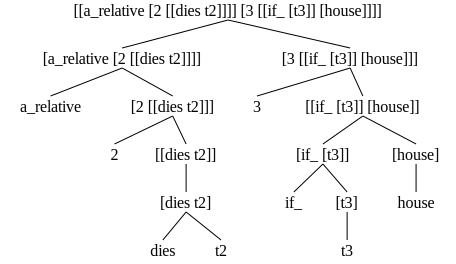

In [23]:
(l * r).source_tree()

In [24]:
(l * r).tree()

1 composition path:<br /><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{a\_relative}}]\!]^{}_{\left\{e\right\}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\{{x}_{e} \:|\: {Relative}({x}_{e})\}$</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{2}}]\!]^{}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>[idx: 2]</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{dies}}]\!]^{}_{\left\langle{}e,t\right\rangle{}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\lambda{} x_{e} \: . \: {Dies}({x}

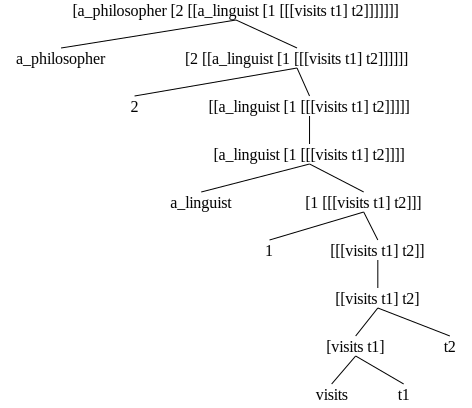

In [25]:
l = a_philosopher * (lang.Binder(2) * ((a_linguist * (lang.Binder(1) * (((visits * lang.Trace(1)) * lang.Trace(2)) * None))) * None))
l.source_tree()

In [26]:
r = lang.Binder(3) * ((if_ * (lang.Trace(3, typ=tp("{t}")))) * house)
r

1 composition path.  Result:<br />
&nbsp;&nbsp;&nbsp;&nbsp;[0]: $[\![\text{\textbf{[3 [[if\_ t3] [house]]]}}]\!]^{}_{\left\langle{}\left\{t\right\},\left\{t\right\}\right\rangle{}} \:=\: \lambda{} x_{\left\{t\right\}} \: . \: \{{If}_{\left\langle{}t,\left\langle{}t,t\right\rangle{}\right\rangle{}}(\textsf{True} \in{} {x})({InheritHouse}_{t})\}$

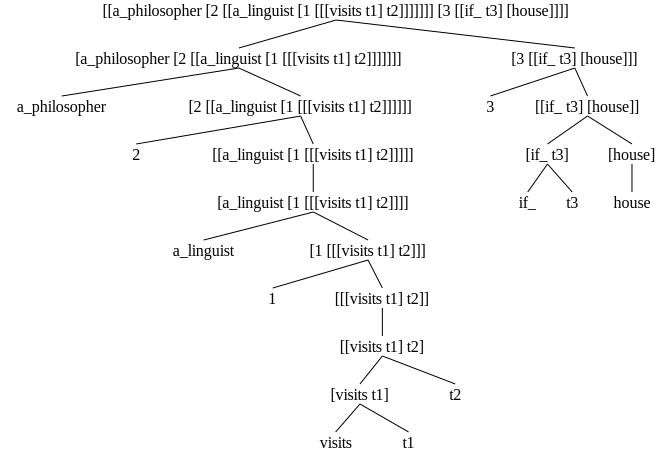

In [27]:
(l * r).source_tree()

In [28]:
(l * r).tree()

1 composition path:<br /><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{a\_philosopher}}]\!]^{}_{\left\{e\right\}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\{{x}_{e} \:|\: {Philosopher}({x}_{e})\}$</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{2}}]\!]^{}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>[idx: 2]</span></div></div></div></div></div></div><div style="display: table-cell; padding-left:4em;"></div><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:table;"><div align="center" style="display:table-row;"><div style="display:table-cell;table-layout:auto;vertical-align:bottom;border-bottom:1px solid #848482;"><div style="display: table;"><div style="vertical-align:bottom;display:table-cell;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div align="center" style="display:block;padding-left:5px;padding-right:5px;padding-top:5px;padding-bottom:5px;"><div style="display:table;table-layout:auto;" align="center"><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$[\![\text{\textbf{a\_linguist}}]\!]^{}_{\left\{e\right\}}$</span></div></div></div><div style="display:table-row;"><div style="display:table-cell;padding-right:2px; padding-left:2px;" align="center"><div style="display:inline-block;"><span>$\{{x}_{e} \:|\: {Linguist}({x}_{e})\}